# Intents Classification for Neural Text Generation
**General Context:**  
The identification of both Dialog Acts (DA) and Emotion/Sentiment (E/S) in spoken language is an important step toward
improving model performances on spontaneous dialogue task. Especially, it is essential to avoid the generic response
problem, i.e., having an automatic dialog system generate an unspecific response — that can be an answer to a very large
number of user utterances. DAs and emotions are identified through sequence labeling systems that are trained in a
supervised manner DAs and emotions have been particularly useful for training ChatGPT.

**Problem Statement:**  
We start by formally defining the Sequence Labelling Problem. At the highest level, we have a set $D$ of conversations
composed of utterances, i.e., $D = (C_1,C_2,\dots,C_{|D|})$ with $Y= (Y_1,Y_2,\dots,Y_{|D|})$ being the corresponding
set of labels (e.g., DA,E/S). At a lower level each conversation $C_i$ is composed of utterances $u$, i.e $C_i= (
u_1,u_2,\dots,u_{|C_i|})$ with $Y_i = (y_1, y_2, \dots, y_{|C_i|})$ being the corresponding sequence of labels: each
$u_i$ is associated with a unique label $y_i$. At the lowest level, each utterance $u_i$ can be seen as a sequence of
words, i.e $u_i = (\omega^i_1, \omega^i_2, \dots, \omega^i_{|u_i|})$.

The goal is to predict Y from D !

**Your Task:**  
Build an intent classifier. Several benchmark have been released involving english [1] or multlingual setting [2]


## Google colab

In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.7 MB/s eta 0:00

## Imports

In [ ]:
from datasets import load_dataset, load_metric

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, get_scheduler

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tqdm.auto import tqdm

## Helpers functions

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["Utterance"], padding="max_length", truncation=True)

def predict(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return names[predictions[0].item()]

## Loading the *dyda_da* dataset 

In [ ]:
dataset = load_dataset("silicone", "dyda_da")
names = dataset["train"].features["Label"].names

Generating train split:   0%|          | 0/87170 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8069 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7740 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Tokenize dataset

### Bert-base-cased

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["Dialogue_ID", "Dialogue_Act", "Idx", "Utterance"])
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
tokenized_datasets.set_format("torch")

### gpt2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenized_datasets = dataset.map(tokenize_function, batched=True)

KeyboardInterrupt: ignored

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["Dialogue_ID", "Dialogue_Act", "Idx", "Utterance"])
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
tokenized_datasets.set_format("torch")

### roberta

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["Dialogue_ID", "Dialogue_Act", "Idx", "Utterance"])
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
tokenized_datasets.set_format("torch")

## Dataloaders

In [ ]:
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=8)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

## Models

In [ ]:
models = {}

### Bert-tiny

In [ ]:
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText + a hidden layer and linear layer for classification
models["bert_tiny"] = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=len(names))

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

### xlm roberta

In [ ]:
models["roberta"] = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(names))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

### gpt2

In [ ]:
models["gpt2"] = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=len(names))

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### roberta-base

In [ ]:
models["roberta_base"] = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=len(names))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

### bert

In [ ]:
models["bert_base"] = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(names))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Hyperparameters

In [ ]:
models.keys()

dict_keys(['bert_tiny', 'bert_base'])

In [ ]:
model = models["bert_base"]

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

## Training loops

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
progress_bar = tqdm(range(num_training_steps))
model.to(device)
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
# Save model
model.save_pretrained('models/dyda_da/bert_tiny')

## Evaluation

In [ ]:
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(test_dataloader), desc="evaluating", total=test_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

evaluating:   0%|          | 0/968 [00:00<?, ?it/s]

{'accuracy': 0.8038759689922481}

In [ ]:
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

  commissive       0.58      0.30      0.39       718
   directive       0.67      0.59      0.63      1278
      inform       0.80      0.90      0.85      3534
    question       0.91      0.94      0.92      2210

    accuracy                           0.80      7740
   macro avg       0.74      0.68      0.70      7740
weighted avg       0.79      0.80      0.79      7740



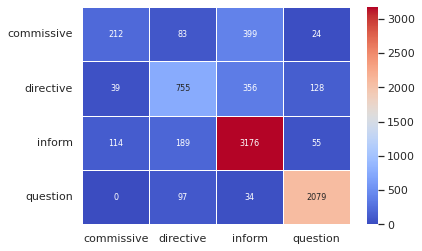

In [ ]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

## Prediction

In [ ]:
# Test with a custom sentence
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('models/dyda_da/bert_tiny', num_labels=len(names))
sentence = "The time will be clear"
print(predict(sentence))

inform


In [ ]:
from transformers import BertModel

# Load pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
